<a href="https://colab.research.google.com/github/wfreeman93/DeepLearningWork/blob/main/wfree3_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using a data set from kaggle, link provided https://www.kaggle.com/andrewmvd/face-mask-detection

In [ ]:
import shutil
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import glob
import xml.etree.ElementTree as ET
import cv2

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/face-mask-detection

100% 398M/398M [00:03<00:00, 157MB/s]



In [ ]:
!unzip /content/face-mask-detection.zip

Archive:  /content/face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotation

In [ ]:
base_dir = 'masks-data'
#delete the directory if already exist
if(os.path.exists(base_dir)):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)

#create subdirectories for train/test/validation  under the base directory
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

#create subdirectories for without_mask, with_mask, mask_weared_incorrect under train directory
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
os.mkdir(train_without_mask_dir)
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
os.mkdir(train_with_mask_dir)
train_mask_weared_incorrect_dir = os.path.join(train_dir, 'mask_weared_incorrect')
os.mkdir(train_mask_weared_incorrect_dir)

#create subdirectories for without_mask, with_mask, mask_weared_incorrect under validation directory
validation_without_mask_dir = os.path.join(validation_dir, 'without_mask')
os.mkdir(validation_without_mask_dir)
validation_with_mask_dir = os.path.join(validation_dir, 'with_mask')
os.mkdir(validation_with_mask_dir)
validation_mask_weared_incorrect_dir = os.path.join(validation_dir, 'mask_weared_incorrect')
os.mkdir(validation_mask_weared_incorrect_dir)

#create subdirectories for without_mask, with_mask, mask_weared_incorrect under test directory
test_without_mask_dir = os.path.join(test_dir, 'without_mask')
os.mkdir(test_without_mask_dir)
test_with_mask_dir = os.path.join(test_dir, 'with_mask')
os.mkdir(test_with_mask_dir)
test_mask_weared_incorrect_dir = os.path.join(test_dir, 'mask_weared_incorrect')
os.mkdir(test_mask_weared_incorrect_dir)

Our annotations are xml files that have classes we care about, whether the mask is on, off, or on incorrectly.
Even more interesting, many of these images have multiple bounding boxes so they can have many different classes per image. During feature scaling I will use these bounding boxes to slice up our images so we have only one class by the bounding box.

This code is sourced from https://www.kaggle.com/stpeteishii/face-mask-get-annotation-info-from-xml from author stpete_ishii on Kaggle

In [ ]:
annotations_directory = "/content/annotations"
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ET.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [ ]:
anno_df = pd.DataFrame(information)

In [ ]:
display(anno_df)

,xmin,ymin,xmax,ymax,label,file,width,height
0,66,25,82,48,with_mask,maksssksksss152,400,283
1,101,41,124,68,with_mask,maksssksksss152,400,283
2,173,34,193,60,with_mask,maksssksksss152,400,283
3,204,75,225,99,with_mask,maksssksksss152,400,283
4,289,25,312,54,with_mask,maksssksksss152,400,283
...,...,...,...,...,...,...,...,...
4067,110,112,161,161,with_mask,maksssksksss585,400,399
4068,162,134,227,210,with_mask,maksssksksss585,400,399
4069,229,120,255,160,without_mask,maksssksksss585,400,399
4070,267,143,326,200,with_mask,maksssksksss585,400,399


So we see here we had origionally 800+ images, now we have over 4000 rows, so each image has on average 4+ distinct mask boundries in it. So we will need to loop over this dataframe, and put cropped images of each record in a new folder and keep going from there.

In [ ]:
cropped_dir = 'cropped_images'
os.makedirs(cropped_dir)
#create subdirectories for the types under the cropped images directory
no_mask = os.path.join(cropped_dir, 'without_mask')
os.mkdir(no_mask)
with_mask = os.path.join(cropped_dir, 'with_mask')
os.mkdir(with_mask)
mask_weared_incorrect = os.path.join(cropped_dir, 'mask_weared_incorrect')
os.mkdir(mask_weared_incorrect)

In [ ]:
for i in range(len(anno_df)):

  image_filepath = '/content/images/' + anno_df['file'].iloc[i] + '.png'
  image = cv2.imread(image_filepath)

  #this part crops our image based on the values given from the xml file
  xmin = anno_df['xmin'].iloc[i]
  ymin = anno_df['ymin'].iloc[i]
  xmax = anno_df['xmax'].iloc[i]
  ymax = anno_df['ymax'].iloc[i]
  cropped_image = image[ymin:ymax, xmin:xmax]
  cropped_image_filename = anno_df['file'].iloc[i] + str(i) + '.png'
  if anno_df['label'].iloc[i] == 'with_mask':
    cropped_image_directory = os.path.join('/content/cropped_images/with_mask', cropped_image_filename) 
    cv2.imwrite(cropped_image_directory, cropped_image)
  elif anno_df['label'].iloc[i] == 'without_mask':
    cropped_image_directory = os.path.join('/content/cropped_images/without_mask', cropped_image_filename)
    cv2.imwrite(cropped_image_directory, cropped_image)
  elif anno_df['label'].iloc[i] == 'mask_weared_incorrect':
    cropped_image_directory = os.path.join('/content/cropped_images/mask_weared_incorrect', cropped_image_filename)
    cv2.imwrite(cropped_image_directory, cropped_image)

In [ ]:
!ls /content/cropped_images/with_mask | wc -l
!ls /content/cropped_images/without_mask | wc -l
!ls /content/cropped_images/mask_weared_incorrect | wc -l

3232
717
123


Now we will split these into train, test, validation sets. an 70/15/15 split for all of them into the masks-data folders to use for our image generator.

In [ ]:
import math
train_with_mask_ct = math.floor(3232 * .7)
train_without_mask_ct = math.floor(717 * .7)
train_mask_weared_incorrect_ct = math.floor(123 * .7)

test_with_mask_ct = math.floor(3232 * .15)
test_without_mask_ct = math.floor(717 * .15)
test_mask_weared_incorrect_ct = math.floor(123 * .15)

val_with_mask_ct = math.floor(3232 * .15)
val_without_mask_ct = math.floor(717 * .15)
val_mask_weared_incorrect_ct = math.floor(123 * .15)

In [ ]:
source = '/content/cropped_images/with_mask'
folder = os.listdir('/content/cropped_images/with_mask/')
for i in range(train_with_mask_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/train/with_mask')
  folder.pop(0)

In [ ]:
#confirming amount is correct, should be 2262ish with rounding, now to do this 8 more times
!ls /content/masks-data/train/with_mask | wc -l

2262


In [ ]:
source = '/content/cropped_images/without_mask'
folder = os.listdir('/content/cropped_images/without_mask/')
for i in range(train_without_mask_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/train/without_mask')
  folder.pop(0)

In [ ]:
source = '/content/cropped_images/mask_weared_incorrect'
folder = os.listdir('/content/cropped_images/mask_weared_incorrect/')
for i in range(train_mask_weared_incorrect_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/train/mask_weared_incorrect')
  folder.pop(0)

In [ ]:
source = '/content/cropped_images/with_mask'
folder = os.listdir('/content/cropped_images/with_mask/')
for i in range(test_with_mask_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/test/with_mask')
  folder.pop(0)

In [ ]:
source = '/content/cropped_images/without_mask'
folder = os.listdir('/content/cropped_images/without_mask/')
for i in range(test_without_mask_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/test/without_mask')
  folder.pop(0)

In [ ]:
source = '/content/cropped_images/mask_weared_incorrect'
folder = os.listdir('/content/cropped_images/mask_weared_incorrect/')
for i in range(test_mask_weared_incorrect_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/test/mask_weared_incorrect')
  folder.pop(0)

In [ ]:
source = '/content/cropped_images/with_mask'
folder = os.listdir('/content/cropped_images/with_mask/')
for i in range(val_with_mask_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/validation/with_mask')
  folder.pop(0)

In [ ]:
source = '/content/cropped_images/without_mask'
folder = os.listdir('/content/cropped_images/without_mask/')
for i in range(val_without_mask_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/validation/without_mask')
  folder.pop(0)

In [ ]:
source = '/content/cropped_images/mask_weared_incorrect'
folder = os.listdir('/content/cropped_images/mask_weared_incorrect/')
for i in range(val_mask_weared_incorrect_ct):
  file = folder[0]
  curr_file = source + '/' + file
  shutil.move(curr_file, '/content/masks-data/validation/mask_weared_incorrect')
  folder.pop(0)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 20
train_dir = '/content/masks-data/train'
validation_dir = '/content/masks-data/validation'

train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(50, 50),
  batch_size=BATCH_SIZE,
  class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(50, 50),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 2849 images belonging to 3 classes.
Found 609 images belonging to 3 classes.


In [ ]:
def build_baseline():
  model=keras.Sequential(
    [
        # first convolution layer + max pooling layer  
        layers.Conv2D(32, (3, 3), activation='relu', padding="same",input_shape=(50, 50, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
                # second convolution layer + max pooling lyaer
        layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # third convolution layer + max pooling lyaer
        layers.Conv2D(128, (3, 3), padding="same",activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # fourth convolution layer + max pooling layer
        layers.Conv2D(128, (3, 3), padding="same",activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        #A global average pooling layer
        layers.GlobalAveragePooling2D(),
        

        # A Dense output layer with softmax activation   
        layers.Dense(3 , activation='softmax')
    ])
  
  # compliling model
  
  #create a learning_rate schedule
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

  #configuring and compiling the model
  opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)

  #returning the model 
  return model

model=build_baseline()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
#callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-3, restore_best_weights=True)

#start the training
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = math.ceil(2849/BATCH_SIZE) ,
            epochs = 50,
            validation_steps = math.ceil(609/BATCH_SIZE),
            callbacks=callback,
            verbose = 1)
model.save("masks-model-base.h5")

Epoch 1/50
143/143 [==============================] - 17s 24ms/step - loss: 0.3527 - accuracy: 0.8757 - val_loss: 1.7187 - val_accuracy: 0.1757
Epoch 2/50
143/143 [==============================] - 3s 20ms/step - loss: 0.2007 - accuracy: 0.9337 - val_loss: 1.8881 - val_accuracy: 0.1757
Epoch 3/50
143/143 [==============================] - 3s 21ms/step - loss: 0.1641 - accuracy: 0.9481 - val_loss: 1.0326 - val_accuracy: 0.5419
Epoch 4/50
143/143 [==============================] - 3s 21ms/step - loss: 0.1362 - accuracy: 0.9565 - val_loss: 0.3187 - val_accuracy: 0.8949
Epoch 5/50
143/143 [==============================] - 3s 21ms/step - loss: 0.1059 - accuracy: 0.9709 - val_loss: 0.1734 - val_accuracy: 0.9425
Epoch 6/50
143/143 [==============================] - 3s 21ms/step - loss: 0.0946 - accuracy: 0.9716 - val_loss: 0.1489 - val_accuracy: 0.9589
Epoch 7/50
143/143 [==============================] - 3s 20ms/step - loss: 0.0808 - accuracy: 0.9744 - val_loss: 0.1410 - val_accuracy: 0.957

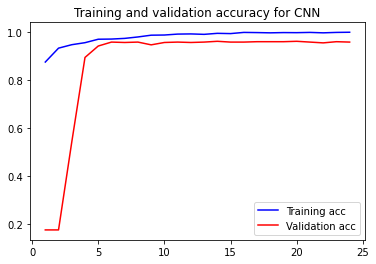

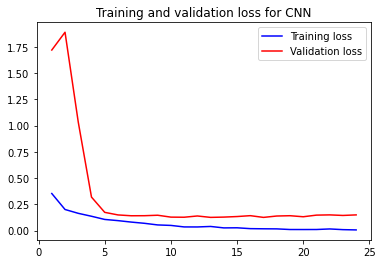

In [ ]:
#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

In [ ]:
test_dir = '/content/masks-data/test'

#read the test images using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),
    batch_size=5,
    class_mode='categorical',
    shuffle = False)

#compute the loss and accurracy on the test set using model.evaluate method
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 609 images belonging to 3 classes.
50/50 [==============================] - 0s 7ms/step - loss: 0.2151 - accuracy: 0.9280
test acc: 0.9279999732971191


In [ ]:
pred_probs = model.predict(test_generator)

In [ ]:
np.argmax(pred_probs, axis=1)

array([0, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix
confused_mat = confusion_matrix(test_generator.classes, np.argmax(pred_probs, axis=1))

In [ ]:
print(confused_mat)

[[  4   9   5]
 [  0 478   6]
 [  0   1 106]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, np.argmax(pred_probs, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36        18
           1       0.98      0.99      0.98       484
           2       0.91      0.99      0.95       107

    accuracy                           0.97       609
   macro avg       0.96      0.73      0.76       609
weighted avg       0.97      0.97      0.96       609



This shows the model performs fairly good when determining a mask or no mask, but is pretty bad comparatively for the mask_weared_incorrect. My hunch is this is due to the large imbalance of the data, and the realitvely low amount of samples of this class, while it be generally very similar in nature to wearing a mask. Next we can try some trasnfer learning from a larger model, maybe such as VGGFace2 to train some more defined face features, then run our data after such features are extracted.

In [ ]:
from tensorflow.keras.applications import VGG19
#rebuild our model
model=build_baseline()

transfer_base = VGG19(weights='imagenet',
include_top=False,
input_shape=(50, 50, 3))

#freeze the weight of the convolutional base
transfer_base.trainable=False

# get the summary of the model to view its architecture
transfer_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import tensorflow.keras.utils 

topClassifier = transfer_base.output

topClassifier=layers.GlobalAveragePooling2D()(topClassifier)

topClassifier = layers.Dense(3, activation="softmax")(topClassifier)

model = Model(inputs=transfer_base.input, outputs=topClassifier)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
#create a learning_rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-4,
  decay_steps=1000,
  decay_rate=0.9)

#configuring and compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=opt)
#callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-3, restore_best_weights=True)

#start the training
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = math.ceil(2849/BATCH_SIZE) ,
            epochs = 50,
            validation_steps = math.ceil(609/BATCH_SIZE),
            callbacks=callback,
            verbose = 1)

Epoch 1/50
143/143 [==============================] - 11s 64ms/step - loss: 0.9487 - accuracy: 0.5746 - val_loss: 0.7232 - val_accuracy: 0.7898
Epoch 2/50
143/143 [==============================] - 8s 58ms/step - loss: 0.6532 - accuracy: 0.7933 - val_loss: 0.6136 - val_accuracy: 0.7931
Epoch 3/50
143/143 [==============================] - 8s 57ms/step - loss: 0.5898 - accuracy: 0.7936 - val_loss: 0.5642 - val_accuracy: 0.7947
Epoch 4/50
143/143 [==============================] - 8s 57ms/step - loss: 0.5522 - accuracy: 0.7936 - val_loss: 0.5278 - val_accuracy: 0.7947
Epoch 5/50
143/143 [==============================] - 8s 57ms/step - loss: 0.5241 - accuracy: 0.7929 - val_loss: 0.4999 - val_accuracy: 0.7947
Epoch 6/50
143/143 [==============================] - 8s 57ms/step - loss: 0.5019 - accuracy: 0.7940 - val_loss: 0.4776 - val_accuracy: 0.7997
Epoch 7/50
143/143 [==============================] - 8s 57ms/step - loss: 0.4839 - accuracy: 0.7975 - val_loss: 0.4589 - val_accuracy: 0.801

In [ ]:
pred_probs = model.predict(test_generator)
print(classification_report(test_generator.classes, np.argmax(pred_probs, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.88      0.96      0.91       484
           2       0.72      0.54      0.62       107

    accuracy                           0.86       609
   macro avg       0.53      0.50      0.51       609
weighted avg       0.82      0.86      0.84       609



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


So this actually seemed to be worse, as now it never predicted an incorrectly weared mask and instead tried to attribute it to either with or without mask.